In [1]:
import utils
utils.assign_free_gpus()
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import tqdm
import numpy as np
import dataloaders
import torchvision
from trainer import Trainer
torch.random.manual_seed(0)
np.random.seed(0)

No GPU available, using CPU


### Dataset

In [2]:
# Load the dataset and print some stats
batch_size = 64

# image_transform_not_normalized = torchvision.transforms.Compose([
#     torchvision.transforms.ToTensor(),
# ])
# dataloader_train_not_normalized, dataloader_test_not_normalized = dataloaders.load_dataset(batch_size, image_transform_not_normalized)


image_transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0.5, 0.5),
])
dataloader_train, dataloader_test = dataloaders.load_dataset(batch_size, image_transform)

print(64*len(dataloader_test))
print(64*len(dataloader_train))
example_images, _ = next(iter(dataloader_train))
print(f"The tensor containing the images has shape: {example_images.shape} (batch size, number of color channels, height, width)",
      f"The maximum value in the image is {example_images.max()}, minimum: {example_images.min()}", sep="\n\t")

10048
60032
The tensor containing the images has shape: torch.Size([64, 1, 28, 28]) (batch size, number of color channels, height, width)
	The maximum value in the image is 1.0, minimum: -1.0


In [12]:
# class myNet(nn.Module):
#     def __init__(self):
#         super(Net, self).__init__()
#         self.fc1 = nn.Linear(28*28, 64)
#         self.fc2 = nn.Linear(64, 64)
#         self.fc3 = nn.Linear(64, 64)
#         self.fc4 = nn.Linear(64, 10)

#     def forward(self, x):
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = F.relu(self.fc3(x))
#         x = self.fc4(x)
#         return F.log_softmax(x, dim=1) 
    
def create_model():
    """
        Initializes the model. Edit the code below if you would like to change the model.
    """
    model = nn.Sequential(
        nn.Flatten(), # Flattens the image from shape (batch_size, C, Height, width) to (batch_size, C*height*width)
        nn.Linear(28*28*1, 10),
        # nn.Linear(28*28*1, 64),
        # nn.ReLU(inplace=True),
        # nn.Linear(64, 10),
        # No need to include softmax, as this is already combined in the loss function
    )

    # Transfer model to GPU memory if a GPU is available
    model = utils.to_cuda(model)
    return model


model1 = create_model()
model2 = create_model()

In [13]:
# Test if the model is able to do a single forward pass
example_images = utils.to_cuda(example_images)
output = model1(example_images)
print("Output shape:", output.shape)
expected_shape = (batch_size, 10) # 10 since mnist has 10 different classes
assert output.shape == expected_shape,    f"Expected shape: {expected_shape}, but got: {output.shape}"

Output shape: torch.Size([64, 10])


### Hyperparameters & Loss function

In [14]:
# Hyperparameters
learning_rate = .0192
learning_rate = 1.0
num_epochs = 5


# Use CrossEntropyLoss for multi-class classification
loss_function = torch.nn.CrossEntropyLoss()

# Define optimizer (Stochastic Gradient Descent)
optimizer1 = torch.optim.SGD(model1.parameters(),
                            lr=learning_rate)

# Define optimizer (Stochastic Gradient Descent)
optimizer2 = torch.optim.SGD(model2.parameters(),
                            lr=learning_rate)

### Train model

In [15]:
trainer = Trainer(
  model=model1,
  dataloader_train=dataloader_train,
  dataloader_test=dataloader_test,
  batch_size=batch_size,
  loss_function=loss_function,
  optimizer=optimizer1
)
train_loss_dict, test_loss_dict = trainer.train(num_epochs)


# trainer_not_normalized = Trainer(
#   model=model2,
#   dataloader_train=dataloader_train_not_normalized,
#   dataloader_test=dataloader_test_not_normalized,
#   batch_size=batch_size,
#   loss_function=loss_function,
#   optimizer=optimizer2
# )
# train_loss_dict_not_normalized, test_loss_dict_not_normalized = trainer_not_normalized.train(num_epochs)



Training epoch 4: 100%|██████████| 938/938 [00:10<00:00, 91.41it/s]


In [ ]:
import json

# Plot RELU


# with open("train_loss_relu.txt", "w") as my_file:
#     my_file.write(json.dumps(train_loss_dict))

# with open("test_loss_relu.txt", "w") as my_file:
#     my_file.write(json.dumps(test_loss_dict))

with open("train_loss_relu.txt", "r") as my_file:
    train_loss_dict_relu = json.loads(my_file.read())

with open("test_loss_relu.txt", "r") as my_file:
    test_loss_dict_relu = json.loads(my_file.read())

# Training loss for relu
keys = list(train_loss_dict_relu.keys())
for i in range(len(keys)):
    keys[i] = int(keys[i])

values = list(train_loss_dict_relu.values())
for i in range(len(values)):
    values[i] = float(values[i])
#plt.plot(keys, values, label="Train Loss relu")

# Test loss for relu
keys = list(test_loss_dict_relu.keys())
for i in range(len(keys)):
    keys[i] = float(keys[i])
values = list(test_loss_dict_relu.values())
for i in range(len(values)):
    values[i] = float(values[i])
#plt.plot(keys, values, label="Train Loss relu")

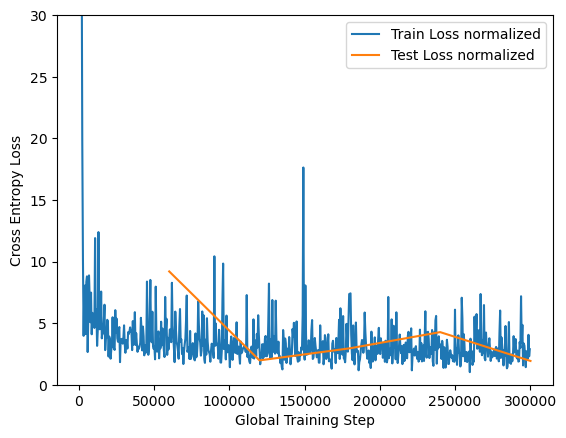

Final Test loss: 1.9295185681363645. Final Test accuracy: 0.9021


In [19]:
# Plot loss not normalized
# keys = list(train_loss_dict_not_normalized.keys())
# values = list(train_loss_dict_not_normalized.values())
# plt.plot(keys, values, label="Train Loss not normalized")

# keys = list(test_loss_dict_not_normalized.keys())
# values = list(test_loss_dict_not_normalized.values())
# plt.plot(keys, values, label="Test Loss not normalized")


# Plot loss
utils.plot_loss(train_loss_dict, label="Train Loss normalized")
utils.plot_loss(test_loss_dict, label="Test Loss normalized")

# Limit the y-axis of the plot (The range should not be increased!)
plt.ylim([0, 30])
plt.legend()
plt.xlabel("Global Training Step")
plt.ylabel("Cross Entropy Loss")
#plt.savefig("image_solutions/task4c.png")

plt.show()

torch.save(model1.state_dict(), "saved_model.torch")
final_loss, final_acc = utils.compute_loss_and_accuracy(
    dataloader_test, model1, loss_function)
print(f"Final Test loss: {final_loss}. Final Test accuracy: {final_acc}")


### Task A

torch.Size([10, 784])


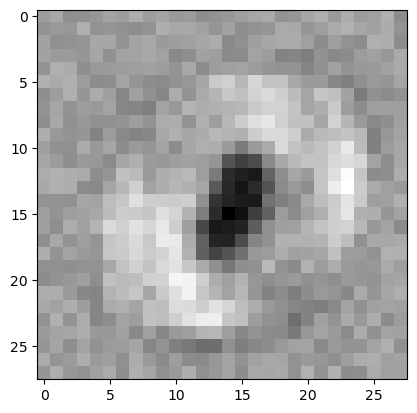

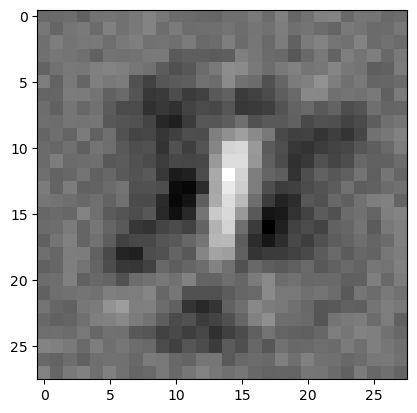

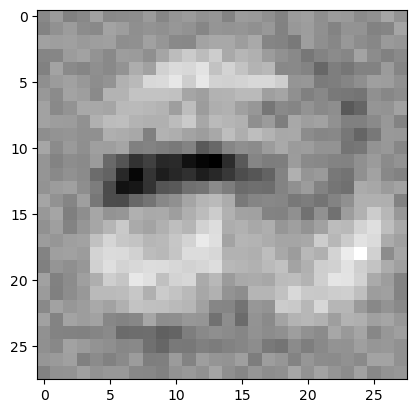

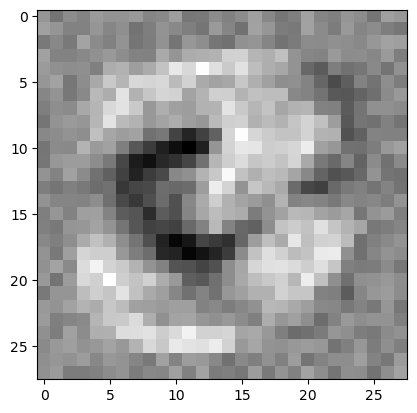

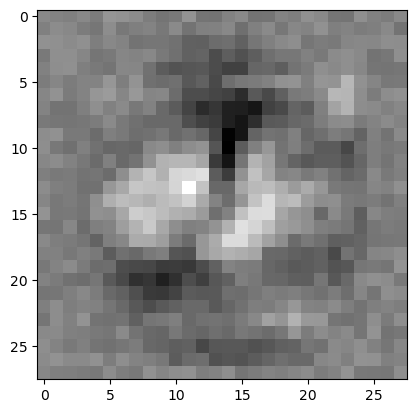

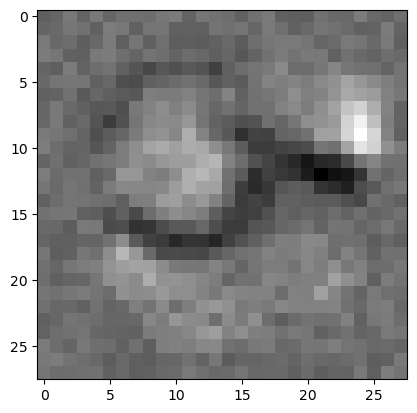

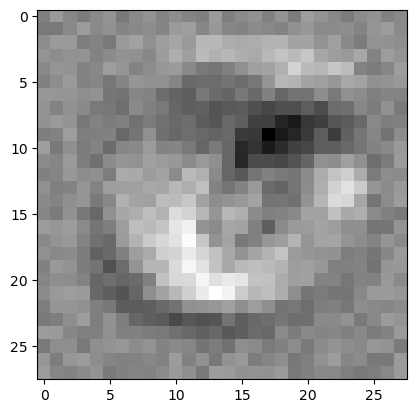

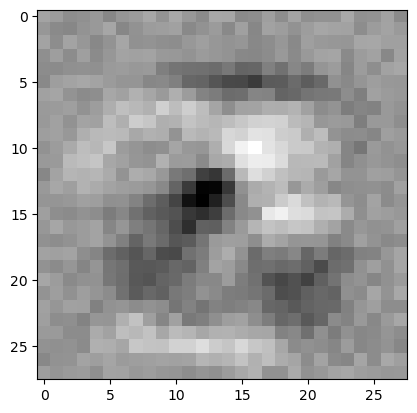

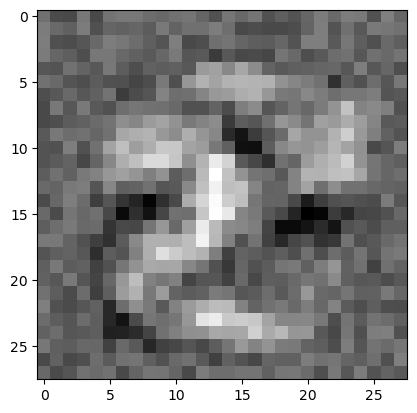

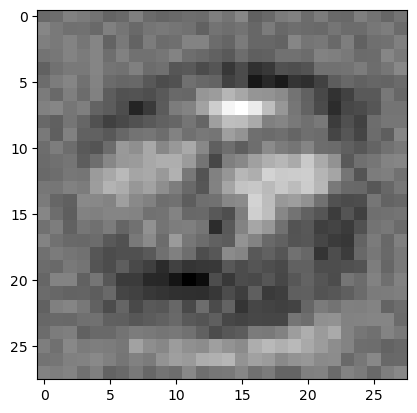

In [31]:
from utils import save_im
weight = list(model.children())[1].weight.cpu().data
print(weight.shape)

for index, number in enumerate(weight):
    
    number_array = np.zeros([28,28])

    for row in range(28):
        for col in range(28):
            number_array[row][col] = number[28*row+col]

    plt.figure(f'Number {index}')
    plt.imshow(number_array, cmap="gray")
    plt.show()
    save_im(f'image_solutions/number{index}.png', number_array, cmap="gray")
    #plt.savefig(f'image_solutions/number{index}.png',f'Number {index}')

### Task B

### Task C

Normalized Lr=0.0192 Final Test loss: 0.291034205253147. Final Test accuracy: 0.9166
Not normalized Lr=0.0192 Final Test loss: 0.3377520941957167. Final Test accuracy: 0.9085

Normalized Lr=1.0 Final Test loss: 2.8491579969802894. Final Test accuracy: 0.8631
Not normalized Lr=1.0 Final Test loss: 20.13892987731156. Final Test accuracy: 0.3359

ReLu Lr=0.0192 Final Test loss: 0.20937791856444754. Final Test accuracy: 0.9393

### Task D